In [33]:
import numpy as np
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # copied over from ipynb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords # tried to use this vocab but ended up with lower accuracy than the built in stopwords
nltk.download('stopwords')

SEED = 12345

In [34]:
from matplotlib import pyplot as plt

import seaborn as sns
#This sets the default style for all figures. 
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [35]:
# load the csv files
if __name__ == '__main__':
    data_dir = '../data_reviews'
    x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
    y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

    N, n_cols = x_train_df.shape
    print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
    print("Shape of y_train_df: %s" % str(y_train_df.shape))

    # Print out the first five rows and last five rows
    tr_text_list = x_train_df['text'].values.tolist()
    rows = np.arange(0, 5)
    for row_id in rows:
        text = tr_text_list[row_id]
        print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

    print("...")
    rows = np.arange(N - 5, N)
    for row_id in rows:
        text = tr_text_list[row_id]
        print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

# Problem 1:

In [36]:
# Splitting up training data into training set and validation set
x_train, x_va, y_train, y_va = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=SEED)
y_train = y_train.values.ravel()
y_va = y_va.values.ravel()

In [37]:
# define logistic regression pipeline function
def make_log_regr_pipeline():
    pipeline = Pipeline(
        steps=[
         ('vectorizer', CountVectorizer(
             lowercase=True, # make the text uniformly lowercase
             stop_words='english', # remove filler words ('a', 'the', etc.) present in the stopwords nltk library
             analyzer='word', # breakdown text into words for feature analysis
            #  ngram_range=(1, 1), 
            # max_features = 750,
             max_df=0.50, # ignore words with a frequency strictly higher than 50%
             token_pattern=r'\b\w+\b' # removes punctuation and numbers
             )
            ),
         ('log_regr', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000)),
        ])
    return pipeline

In [38]:
# initialize pipeline
pipe = make_log_regr_pipeline()

# # make hyperparameter C grid (regularization strength), 20 logspaced values from 10e-6 to 10e6
# C_grid = np.logspace(-4, 4, 20)
# param_grid = {'log_regr__C': C_grid}

In [39]:
# make hyperparameter C grid (regularization strength), 20 logspaced values from 10e-6 to 10e6
C_grid = np.logspace(-10, 10, 20)
param_grid = {'log_regr__C': C_grid}

# perform grid search and fit the model
grid_search = GridSearchCV(
    pipe, # estimator
    param_grid=param_grid, # hyperparameter C
    cv=5, # 5-fold cross validation
    scoring='roc_auc', # calculates AUROC to compare the hyperparameter(s)
    return_train_score = True
)

grid_search.fit(x_train['text'], y_train)
grid_predictions_va = grid_search.predict(x_va['text'])
grid_predictions_tr = grid_search.predict(x_train['text'])

# calculate and print accuracy for training and validation datasets
print("Training Accuracy:", accuracy_score(y_train, grid_predictions_tr))
print("Validation Accuracy:", accuracy_score(y_va, grid_predictions_va))

# best parameter found in the grid search
print("Best C:", grid_search.best_params_)

Training Accuracy: 0.9770833333333333
Validation Accuracy: 0.80625
Best C: {'log_regr__C': 3.359818286283774}


In [40]:
_, fp, fn, _ = confusion_matrix(y_va, grid_predictions_va).ravel()
FP = []
FN = []

for i, pred in enumerate(grid_predictions_va):
    if pred == 1 and y_va[i] == 0:
        FP.append(i)
    if pred == 0 and y_va[i] == 1:
        FN.append(i)

# print(FP)

# print(x_va.iloc[FP[0]])

# pd.set_option('display.max_colwidth', None)
# pd.set_option("display.colheader_justify","left")
pd.set_option('display.max_colwidth', 10000)

va_idx_FP = FP[0:10]
va_sent_predict_FP = grid_predictions_va[va_idx_FP]
va_sent_true_FP = y_va[va_idx_FP]
FP_styled_df = x_va.iloc[va_idx_FP].style.set_properties(**{'text_align': 'right'})

print("FP data:")
print("FP indices chosen:", va_idx_FP)
print("FP predictions and true sentiments", va_sent_predict_FP, va_sent_true_FP)
print("Sentences that were FP: \n")
FP_styled_df

FP data:
FP indices chosen: [4, 7, 8, 13, 34, 42, 43, 47, 65, 84]
FP predictions and true sentiments [1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0]
Sentences that were FP: 



,website_name,text
1907,yelp,"for 40 bucks a head, i really expect better food."
1964,yelp,I also decided not to send it back because our waitress looked like she was on the verge of having a heart attack.
846,imdb,"But this movie is not funny, considering the ridiculousness of it."
1743,yelp,I was disgusted because I was pretty sure that was human hair.
193,amazon,"The loudspeaker option is great, the bumpers with the lights is very ... appealing."
1640,yelp,"When my order arrived, one of the gyros was missing."
42,amazon,Unfortunately the ability to actually know you are receiving a call is a rather important feature and this phone is pitiful in that respect.
1706,yelp,Soggy and not good.
204,amazon,If you plan to use this in a car forget about it.
1692,yelp,say bye bye to your tip lady!


In [41]:
va_idx_FN = FN[0:10]
va_sent_predict_FN = grid_predictions_va[va_idx_FN]
va_sent_true_FN = y_va[va_idx_FN]
FN_styled_df = x_va.iloc[va_idx_FN].style.set_properties(**{'text_align': 'right'})

print("FN data:")
print("FN indices chosen:", va_idx_FN)
print("FN predictions and true sentiments", va_sent_predict_FN, va_sent_true_FN)
print("Sentences that were FN: \n")
FN_styled_df

FN data:
FN indices chosen: [9, 20, 41, 48, 67, 69, 79, 88, 96, 116]
FN predictions and true sentiments [0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1 1 1]
Sentences that were FN: 



,website_name,text
2355,yelp,"The sides are delish - mixed mushrooms, yukon gold puree, white corn - beateous."
2378,yelp,"Lordy, the Khao Soi is a dish that is not to be missed for curry lovers!"
1450,imdb,"This is a witty and delightful adaptation of the Dr Seuss book, brilliantly animated by UPA's finest and thoroughly deserving of its Academy Award."
1539,imdb,You wont regret it!
2374,yelp,The goat taco didn't skimp on the meat and wow what FLAVOR!
1563,imdb,I don't think you will be disappointed.
1425,imdb,"The characters are fleshed out surprisingly well, particularly Grimes and Blake, and all the actors deliver their sharply scripted lines with just the right amount of deadpan tongue in cheek to make the dialogue both hilarious and realistic."
492,amazon,Their Research and Development division obviously knows what they're doing.
666,amazon,I did not have any problem with this item and would order it again if needed.
1452,imdb,He's a national treasure.


In [42]:
#  # print best parameter and best score
# print(f'Best C: {grid_search.best_params_["log_regr__C"]}')
# print(f'Best AUROC score: {grid_search.best_score_}')

# # plot the performance of different regularization strengths
# va_scores = grid_search.cv_results_['mean_test_score']
# tr_scores = grid_search.cv_results_['mean_train_score']
# std_train_score = grid_search.cv_results_['std_train_score']
# std_va_score = grid_search.cv_results_['std_test_score']

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(C_grid, [va_scores, tr_scores], marker='o')
# ax.set_xscale('log')
# ax.set_xlabel('C (Inverse Regularization Strength)')
# ax.set_ylabel('Mean AUROC')
# ax.set_title('Effect of C on AUROC (5-fold CV)')
# plt.show()

The peak of the graph indicates the best C value - this will prevent over- and under-fitting to the training data. 

In [43]:
grid_search.cv_results_

{'mean_fit_time': array([0.04138985, 0.03989348, 0.04485836, 0.06218543, 0.04820843,
        0.04037976, 0.0420876 , 0.08113265, 0.05596557, 0.05331779,
        0.10114698, 0.19614844, 0.24641156, 0.51448469, 1.23142343,
        2.07650013, 2.88389611, 1.30465665, 0.35980301, 0.25397444]),
 'std_fit_time': array([0.00785022, 0.0017319 , 0.003824  , 0.02258106, 0.00595192,
        0.00201191, 0.00378237, 0.03210083, 0.01172415, 0.00568221,
        0.02617071, 0.05538172, 0.06432994, 0.1232977 , 0.28376376,
        0.73335227, 1.0107524 , 0.68605484, 0.15059754, 0.13495138]),
 'mean_score_time': array([0.00782285, 0.00709553, 0.00848379, 0.01113915, 0.00893922,
        0.00778265, 0.00802684, 0.01020784, 0.01124363, 0.0077302 ,
        0.01018806, 0.00953403, 0.01017847, 0.01376448, 0.00819492,
        0.0069499 , 0.01172838, 0.01322951, 0.01251144, 0.01533995]),
 'std_score_time': array([0.00060579, 0.00052707, 0.00158417, 0.00359975, 0.00131846,
        0.00173622, 0.00172963, 0.002607

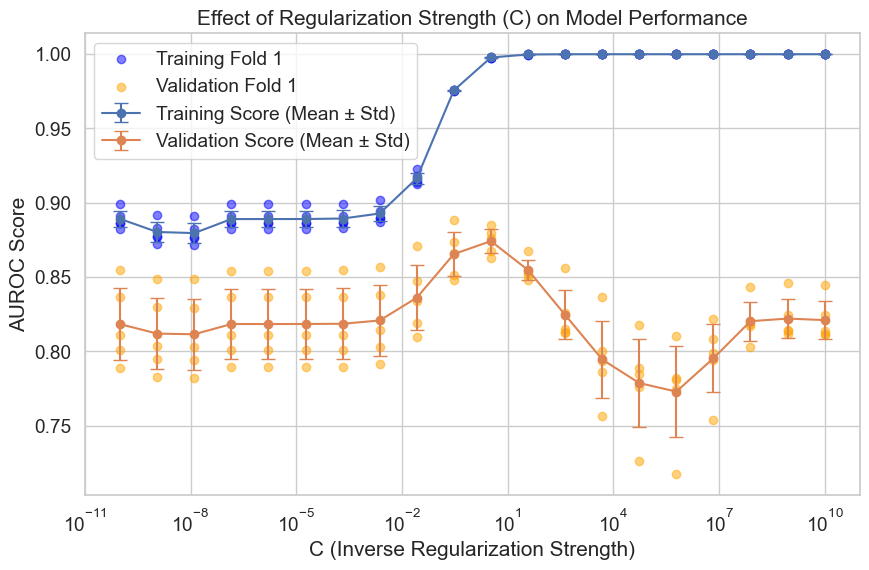

In [44]:
# Extract the results from grid search
mean_train_score = grid_search.cv_results_['mean_train_score']
mean_test_score = grid_search.cv_results_['mean_test_score']

# Extract the standard deviation for training and validation folds
std_train_score = grid_search.cv_results_['std_train_score']
std_test_score = grid_search.cv_results_['std_test_score']

# Extract the scores of each fold for both training and validation sets
train_scores = grid_search.cv_results_['split0_train_score'], grid_search.cv_results_['split1_train_score'], \
               grid_search.cv_results_['split2_train_score'], grid_search.cv_results_['split3_train_score'], \
               grid_search.cv_results_['split4_train_score']

test_scores = grid_search.cv_results_['split0_test_score'], grid_search.cv_results_['split1_test_score'], \
              grid_search.cv_results_['split2_test_score'], grid_search.cv_results_['split3_test_score'], \
              grid_search.cv_results_['split4_test_score']

# Plot the performance of different regularization strengths
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean train and validation scores with standard deviation as error bars
ax.errorbar(C_grid, mean_train_score, yerr=std_train_score, label='Training Score (Mean ± Std)', fmt='-o', capsize=5)
ax.errorbar(C_grid, mean_test_score, yerr=std_test_score, label='Validation Score (Mean ± Std)', fmt='-o', capsize=5)

# Add individual fold performance as points
for i in range(5):
    ax.scatter(C_grid, train_scores[i], alpha=0.5, color='blue', label=f'Training Fold {i+1}' if i == 0 else "")
    ax.scatter(C_grid, test_scores[i], alpha=0.5, color='orange', label=f'Validation Fold {i+1}' if i == 0 else "")

# Set log scale for x-axis
ax.set_xscale('log')

# Set labels and title
ax.set_xlabel('C (Inverse Regularization Strength)')
ax.set_ylabel('AUROC Score')
ax.set_title('Effect of Regularization Strength (C) on Model Performance')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [45]:
x_test = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
grid_predictions_test = grid_search.predict(x_test['text'])
grid_predictions_test_T = np.transpose(grid_predictions_test)
print(str(grid_predictions_test_T))

file = open("yproba1_test.txt", "w+")
for value in grid_predictions_test:
    line = str(value) + "\n"
    file.write(line)
file.close()



[1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1
 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0
 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 0 